In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# reading in the table occupancy sheet to choose the top genes
genesheet = pd.read_csv("TableOccupancy_full.csv")
genelist = list()
genedict = dict()
genedict1 = dict()

In [4]:
# setting the number of genes to be analyzed
all_count = 1000
top_count = 25

In [5]:
# creating a dictionary for the top genes
genedict = dict((d['Gene'], d['Count']) for d in genesheet.head(all_count)[['Gene', 'Count']].to_dict(orient='records'))

In [6]:
# adding number of references to the dataframe

collist = list()
colref = list()

db_ref = pd.read_excel(f"simplemine_results_TableOccupancy_full_27Sep2024.xlsx", comment="#")

for gene in genedict.keys():
    geneindex = db_ref[db_ref["Your Input"] == gene].index[0]
    line = db_ref.at[geneindex, "Reference"]
    collist.append(str(line))
      
for element in collist:
    new = element.split(',')
    if new != ['N.A.']:
        colref.append(len(new))
    else:
        colref.append(0)

In [7]:
df = pd.DataFrame(genedict.keys())

In [8]:
df.columns = ['Gene']

In [9]:
df.head()

,Gene
0,WBGene00021107
1,WBGene00021106
2,WBGene00017069
3,WBGene00016953
4,WBGene00007454


In [10]:
# creating a new column in the df called 'References'
df['References'] = colref

In [11]:
df

,Gene,References
0,WBGene00021107,0
1,WBGene00021106,0
2,WBGene00017069,3
3,WBGene00016953,1
4,WBGene00007454,0
...,...,...
995,WBGene00022564,0
996,WBGene00012855,1
997,WBGene00007331,1
998,WBGene00009115,0


In [12]:
# creating a list of files in the database
filelist = os.listdir("../data_full")
filelist.remove(".DS_Store") if ".DS_Store" in filelist else None

In [13]:
# changing the working directory
os.chdir("../data_full")

In [14]:
# creating a list of file names to be iterated over

newcolname = list()
filedict = dict()

for file in filelist:
    db = pd.read_csv(file, comment="#")
    numgene = len(db)
    filedict[file] = numgene

newdict = dict(sorted(filedict.items(), key=lambda item: item[1], reverse=True))

filelist = list(newdict.keys())

In [15]:
# calculating the r-score for each gene
count = 0
N = len(filelist)
arr = list()
r_list = list()
for gene in genedict:
    count += 1
    n = 0
    S_list = []
    T_list = [] 
    for file in filelist:
        db = pd.read_csv(file, comment="#")
        S = 0
        T_list.append(len(db))
        if gene in db["Suggested Match"].values:
            S += 1
        if S > 0:
            n += 1
            
        S_list.append(S)
    arr.append(S_list)
    
    r = 0
    for i in range(n):
        r += S_list[i] / T_list[i]
    
    r_list.append(r)


In [16]:
df['r'] = r_list

In [17]:
df.sort_values(by='r', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.head(top_count)

In [18]:
genes = df['Gene']


In [19]:
os.chdir("../code_and_resources")
wormbase = pd.read_csv('Wormbase_Gene_Sanitizer_Database_DownloadedOn_10-30-2023.txt', comment="#", sep="\t")

In [20]:
new_names = []
for gene in genes:
    result = wormbase.index[wormbase["Public Name For"] == gene].item()
    new_names.append(wormbase.iloc[result, 0])

In [21]:
df['Gene'] = new_names

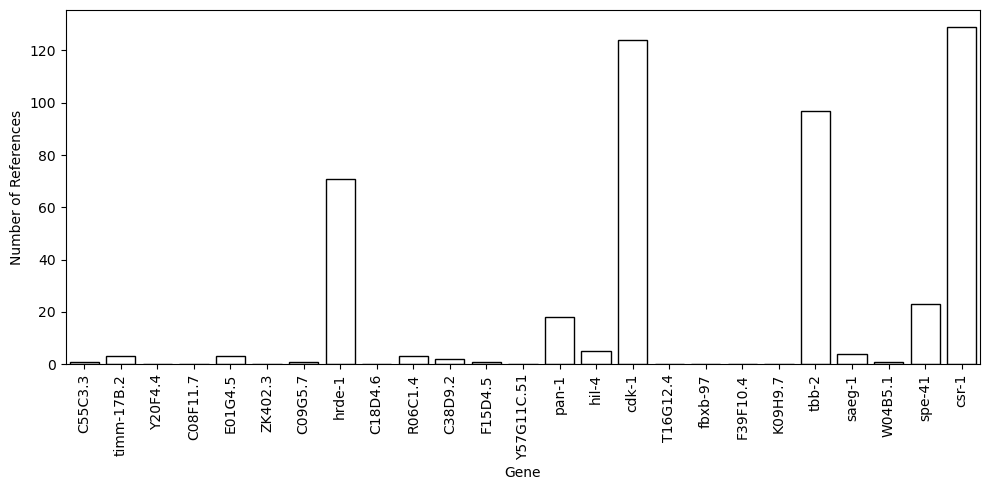

In [22]:
plt.figure(figsize=(10, 5))
fig1= sns.barplot(x='Gene', y='References', data=df, color='white', edgecolor='black')

plt.xlabel('Gene')
plt.ylabel('Number of References')
plt.xticks(rotation=90)

plt.savefig('r25_references_with_1000_total.svg', format='svg', dpi=300)
plt.tight_layout()
